# **Hands On Graph Neural Networks Using Python  -  CHAPTER 6**

- This code performs various operations on graph data using PyTorch Geometric and other libraries.

- It starts by setting random seeds for reproducibility. It then demonstrates linear algebra operations, including matrix inversion.

- The script visualizes node degree distributions for two datasets:
  - Cora from the Planetoid dataset and the Facebook Page-Page dataset.
  
- A Graph Convolutional Network (GCN) is created and trained for node classification on these datasets. Additionally, a GCN is extended for regression tasks and trained on the Wikipedia Network dataset.

- The script also includes utilities for loading data, plotting distributions, and evaluating model performance with metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE).

- Finally, it plots the regression results to compare ground truth versus predicted values.

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from torch_geometric.datasets import Planetoid, FacebookPagePage, WikipediaNetwork
from torch_geometric.utils import degree
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.transforms import RandomNodeSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile


### **SeedSetter Class**

- The SeedSetter class is responsible for setting random seeds across various libraries to ensure reproducibility of experiments.

- It configures seeds for PyTorch, NumPy, and CUDA operations, and sets PyTorch’s backend configurations to deterministic mode.

In [11]:
# Set random seeds for reproducibility
class SeedSetter:
    @staticmethod
    def set_seeds(seed=1):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)


### **LinearAlgebraOperations Class**

- The LinearAlgebraOperations class provides methods for performing linear algebra operations.

- Specifically, it includes functionality to compute matrix inverses and demonstrate their application.

- This class helps in understanding matrix manipulations and their effects on linear systems.

In [12]:
# Linear Algebra Operations
class LinearAlgebraOperations:
    @staticmethod
    def inverse_operations():
        D = np.array([
            [3, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 2, 0],
            [0, 0, 0, 2]
        ])
        print(np.linalg.inv(D))
        print(np.linalg.inv(D + np.identity(4)))

        A = np.array([
            [1, 1, 1, 1],
            [1, 1, 0, 0],
            [1, 0, 1, 1],
            [1, 0, 1, 1]
        ])

        print(np.linalg.inv(D + np.identity(4)) @ A)
        print()
        print(A @ np.linalg.inv(D + np.identity(4)))

### **DatasetVisualizer Class**

- The DatasetVisualizer class contains methods for visualizing graph data.

- It provides functions to visualize node degree distributions for datasets such as Cora (Planetoid dataset) and Facebook Page-Page.

- This visualization helps in understanding the structure and connectivity of nodes in the graph datasets.

In [13]:
# Dataset and Data Visualization
class DatasetVisualizer:
    @staticmethod
    def visualize_planetoid():
        dataset = Planetoid(root=".", name="Cora")
        data = dataset[0]
        degrees = degree(data.edge_index[0]).numpy()
        numbers = Counter(degrees)

        fig, ax = plt.subplots()
        ax.set_xlabel('Node degree')
        ax.set_ylabel('Number of nodes')
        plt.bar(numbers.keys(), numbers.values())
        plt.show()

    @staticmethod
    def visualize_facebook_page():
        dataset = FacebookPagePage(root=".")
        data = dataset[0]
        data.train_mask = range(18000)
        data.val_mask = range(18001, 20000)
        data.test_mask = range(20001, 22470)

        degrees = degree(data.edge_index[0]).numpy()
        numbers = Counter(degrees)

        fig, ax = plt.subplots()
        ax.set_xlabel('Node degree')
        ax.set_ylabel('Number of nodes')
        plt.bar(numbers.keys(), numbers.values())
        plt.show()


### **GCN Class**

- The GCN class defines a Graph Convolutional Network (GCN) model for node classification tasks.

- It includes methods for building the network architecture, training the model using cross-entropy loss, and evaluating its performance.

- This class is used to classify nodes in graph datasets based on their features and connections.

In [14]:
# Graph Convolutional Network Class
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask].long())
            acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask].long()).float().mean()
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask].long())
                val_acc = (out[data.val_mask].argmax(dim=1) == data.y[data.val_mask].long()).float().mean()
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = (out.argmax(dim=1)[data.test_mask] == data.y[data.test_mask].long()).float().mean()
        return acc

### **GCNRegressor Class**

- The GCNRegressor class extends the basic GCN model to handle regression tasks.

- It includes additional convolutional layers and a linear layer for predicting continuous values.

- This class is used for tasks where the goal is to predict a numerical value rather than a class label, such as in the Wikipedia Network dataset.

In [15]:
# Extended GCN for Regression
class GCNRegressor(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h * 4)
        self.gcn2 = GCNConv(dim_h * 4, dim_h * 2)
        self.gcn3 = GCNConv(dim_h * 2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())


### **Utils Class**

- The Utils class provides utility functions for handling graph data and plotting.

- It includes methods to load data from external sources, plot degree and target distributions, and perform other auxiliary tasks that support data analysis and model evaluation.

In [16]:
# Utilities Class
class Utils:
    @staticmethod
    def load_wikipedia_data():
        url = 'https://snap.stanford.edu/data/wikipedia.zip'
        with urlopen(url) as zurl:
            with ZipFile(BytesIO(zurl.read())) as zfile:
                zfile.extractall('.')
        df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
        values = np.log10(df['target'])
        return torch.tensor(values)

    @staticmethod
    def plot_degree_distribution(data):
        degrees = degree(data.edge_index[0]).numpy()
        numbers = Counter(degrees)
        fig, ax = plt.subplots()
        ax.set_xlabel('Node degree')
        ax.set_ylabel('Number of nodes')
        plt.bar(numbers.keys(), numbers.values())
        plt.show()

    @staticmethod
    def plot_target_distribution(df, values):
        df['target'] = values
        fig = sns.histplot(df['target'], kde=True, stat='density', linewidth=0)
        plt.show()


[[0.33333333 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5       ]]
[[0.25       0.         0.         0.        ]
 [0.         0.5        0.         0.        ]
 [0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.33333333]]
[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


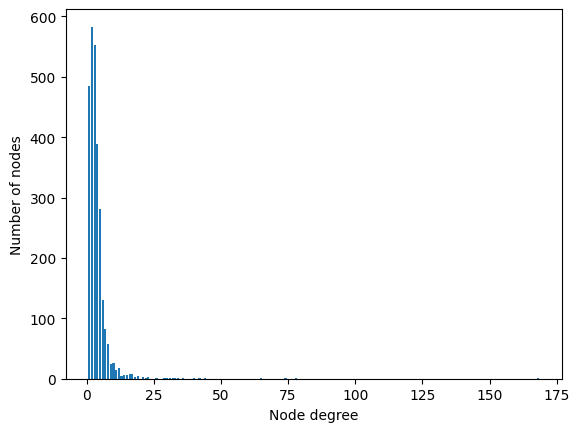

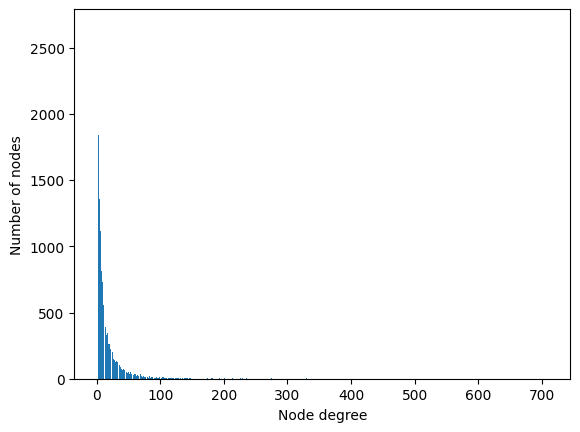

In [18]:
SeedSetter.set_seeds()                                                                              # Set seeds
LinearAlgebraOperations.inverse_operations()                                                        # Linear Algebra Operations
DatasetVisualizer.visualize_planetoid()                                                             # Planetoid Dataset Visualization
DatasetVisualizer.visualize_facebook_page()                                                         # Facebook Page Dataset Visualization
dataset = Planetoid(root=".", name="Cora")                                                          # Load Planetoid Dataset
data = dataset[0]

### **Create and Train GCN Model**

In [19]:
gcn_classification = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn_classification)
gcn_classification.fit(data, epochs=100)
acc = gcn_classification.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



### **Load Facebook Page-Page Dataset**

In [20]:
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

### **Train GCN Model on Facebook Dataset**

In [21]:
gcn_classification = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn_classification)
gcn_classification.fit(data, epochs=100)
acc = gcn_classification.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.463 | Train Acc: 20.72% | Val Loss: 1.45 | Val Acc: 20.71%
Epoch  20 | Train Loss: 0.443 | Train Acc: 84.64% | Val Loss: 0.43 | Val Acc: 85.29%
Epoch  40 | Train Loss: 0.323 | Train Acc: 89.59% | Val Loss: 0.31 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.278 | Train Acc: 91.36% | Val Loss: 0.27 | Val Acc: 91.55%
Epoch  80 | Train Loss: 0.254 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.75%
Epoch 100 | Train Loss: 0.238 | Train Acc: 92.82% | Val Loss: 0.25 | Val Acc: 92.75%

GCN test accuracy: 91.70%



### **Load Wikipedia Network Dataset**

In [22]:
dataset = WikipediaNetwork(root=".", name="chameleon", transform=RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]
data.y = Utils.load_wikipedia_data()

### **Print Dataset and Graph Information**

In [23]:
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


### **Plot Degree Distribution and Target Distribution**

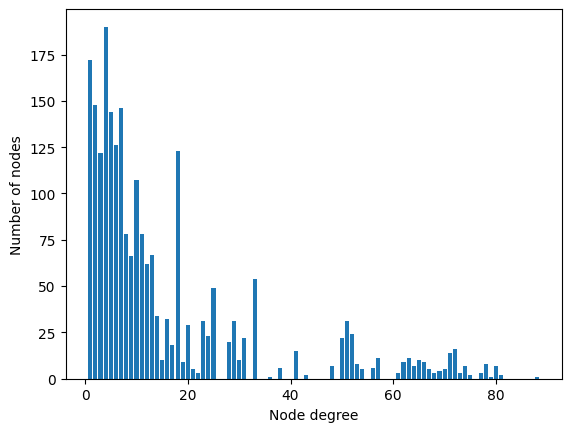

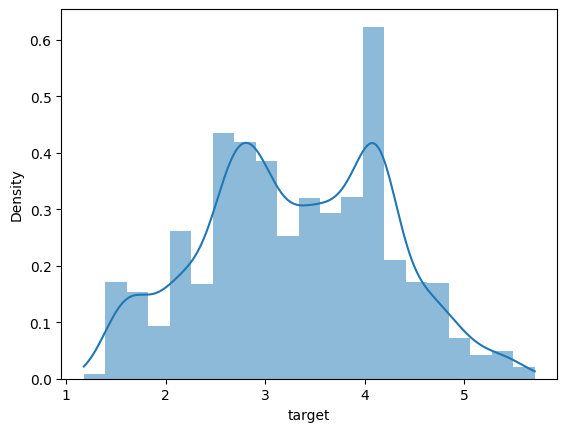

In [24]:
Utils.plot_degree_distribution(data)
df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
Utils.plot_target_distribution(df, values)

### **Create and Train GCN Regressor Model**

In [25]:
gcn_regressor = GCNRegressor(dataset.num_features, 128, 1)
print(gcn_regressor)
gcn_regressor.fit(data, epochs=200)
loss = gcn_regressor.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

GCNRegressor(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.81936 | Val Loss: 13.00659
Epoch  20 | Train Loss: 11.71822 | Val Loss: 11.76676
Epoch  40 | Train Loss: 10.29417 | Val Loss: 10.34435
Epoch  60 | Train Loss: 8.67988 | Val Loss: 8.72097
Epoch  80 | Train Loss: 4.03177 | Val Loss: 4.00313
Epoch 100 | Train Loss: 1.94211 | Val Loss: 2.00301
Epoch 120 | Train Loss: 0.97431 | Val Loss: 1.10883
Epoch 140 | Train Loss: 0.73376 | Val Loss: 0.89986
Epoch 160 | Train Loss: 0.58745 | Val Loss: 0.79570
Epoch 180 | Train Loss: 0.52040 | Val Loss: 0.79910
Epoch 200 | Train Loss: 0.50753 | Val Loss: 0.69298

GCN test loss: 0.72017



### **Compute Metrics**

In [26]:
out = gcn_regressor(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)
print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7202 | RMSE = 0.8486 | MAE = 0.6834


### **Plot Regression Results**

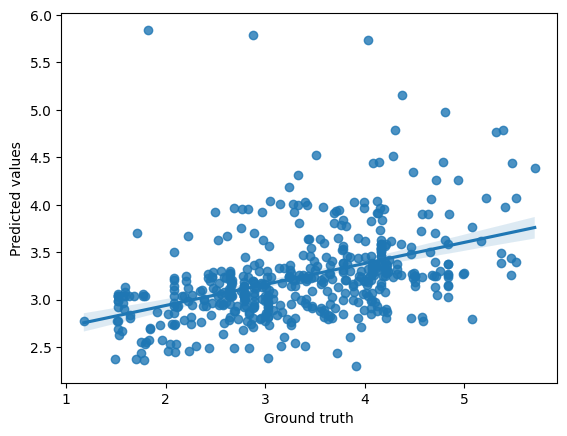

In [27]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')
plt.show()